# Decision Tree Modeling

In [1]:
# 패키지
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DTC
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터
df_raw = load_iris()
import copy
df = copy.deepcopy(df_raw)
# 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(df.data, df.target, test_size = 0.2, random_state = 11)
# Decision Tree
dt = DTC(random_state = 156)
dt.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=156)

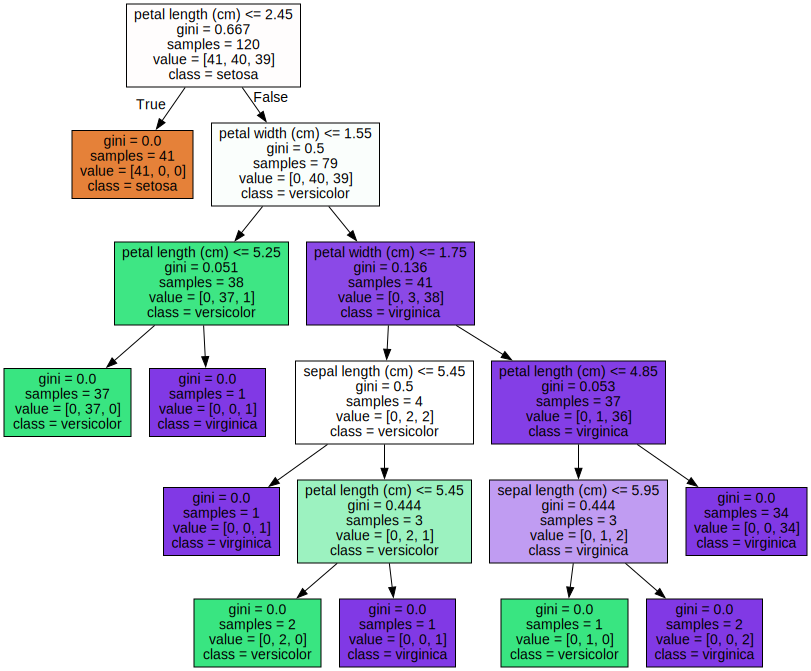

In [3]:
# graphviz
import graphviz
from sklearn.tree import export_graphviz
# 시각화
export_graphviz(dt,
                out_file = 'tree.dot',
                class_names = df.target_names,
                feature_names = df.feature_names,
                impurity = True,
                filled = True)

with open('tree.dot') as f :
    dot_graph = f.read()
graphviz.Source(dot_graph)

sepal length (cm) : 0.025
sepal width (cm) : 0.000
petal length (cm) : 0.555
petal width (cm) : 0.420


<AxesSubplot:>

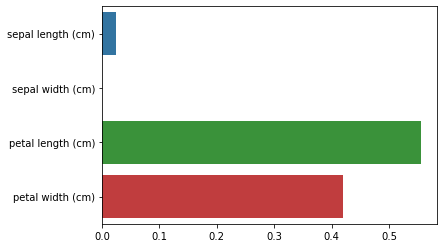

In [4]:
import numpy as np
import seaborn as sns
%matplotlib inline
# feature importance
for name, value in zip(df.feature_names, dt.feature_importances_) :
    print('{} : {:.3f}'.format(name, value))
# 시각화
sns.barplot(x = dt.feature_importances_, y = df.feature_names)

* petal length의 설명변수 중요도가 가장 높은 것을 확인

# Overfitting

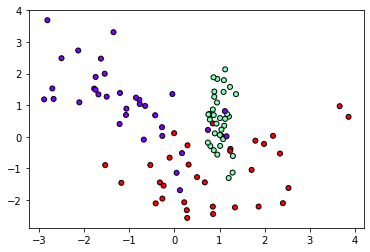

In [5]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
%matplotlib inline

# class 3가지 분류
X, Y = make_classification(n_features = 2,
                           n_redundant = 0,
                           n_informative = 2,
                           n_classes = 3,
                           n_clusters_per_class = 1,
                           random_state = 0)
# 시각화
plt.scatter(X[:,0],
            X[:,1],
            marker = 'o',
            c = Y,
            s = 25,
            cmap = 'rainbow',
            edgecolor = 'k')

In [6]:
# 분류 시각화 함수
def visual_boundary(model, x, y) :
    # 그래프
    fig, ax = plt.subplots()
    # scatter plot
    ax.scatter(x[:,0],x[:,1],
               c = y,
               s = 25, 
               cmap = 'rainbow',
               edgecolor = 'k',
               clim = (y.min(), y.max()), zorder = 3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start, xlim_end = ax.get_xlim()
    ylim_start, ylim_end = ax.get_ylim()
    # 학습
    model.fit(x,y)
    # 좌표값 예측
    xx, yy = np.meshgrid(np.linspace(xlim_start, xlim_end, num = 200),
                         np.linspace(ylim_start, ylim_end, num = 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    # 시각화
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z,
                           alpha = 0.3,
                           levels = np.arange(n_classes + 1) - 0.5,
                           cmap = 'rainbow',
                           clim = (y.min(), y.max()),
                           zorder = 1)

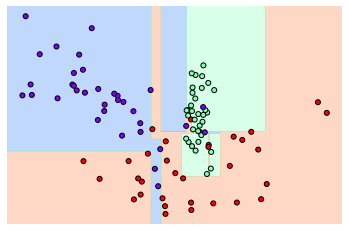

In [7]:
# 트리 생성에 제약이 없는 Decision Tree 시각화
dt = DTC(random_state = 156).fit(X, Y)
visual_boundary(dt, X, Y)

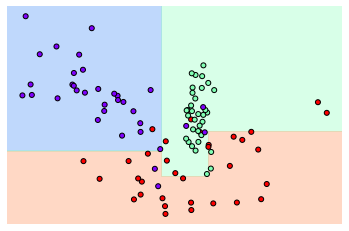

In [8]:
# Hyper Parameter 중 min_samples_leaf = 6 으로 제약한 시각화
dt = DTC(random_state = 156,
         min_samples_leaf = 6).fit(X, Y)
visual_boundary(dt, X, Y)

* 이처럼 Hyper Parameter를 조정하여 과적합을 제어해야 한다.

# 실습 : Human Activity Recognition

### 데이터

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# txt 파일 DataFrame 형태로 불러오기
feature_name_data = pd.read_csv('./data_1/features.txt',
                                sep = '\s+', # 공백 문자 할당
                                names = ['column_index','column_name'])
# feature 이름만 리스트 객체로 생성
feature_name = feature_name_data.iloc[:,1].values.tolist()
print(feature_name[:10])

['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [13]:
# 중복값 확인
feature_gb = feature_name_data.groupby('column_name').count()
print(feature_gb[feature_gb['column_index'] > 1].count())
feature_gb[feature_gb['column_index'] > 1].head(10)

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3
"fBodyAcc-bandsEnergy()-25,32",3
"fBodyAcc-bandsEnergy()-25,48",3
"fBodyAcc-bandsEnergy()-33,40",3
"fBodyAcc-bandsEnergy()-33,48",3


* 중복값으로 인하여 Pandas에서 중복값 에러가 발생할 수 있으므로 feature 이름에 '_숫자'를 부여

In [15]:
# 이름 변경 함수
def get_new_name(old_feature_name_data) :
    feature_gb = pd.DataFrame(data = old_feature_name_data.groupby('column_name').cumcount(),
                              columns = ['cnt_gb'])
    feature_gb = feature_gb.reset_index()
    new_feature_name_data = pd.merge(old_feature_name_data.reset_index(),
                                     feature_gb,
                                     how = 'outer')
    new_feature_name_data['column_name'] = new_feature_name_data[['column_name','cnt_gb']].apply(lambda x : x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis = 1)
    new_feature_name_data = new_feature_name_data.drop(['index'], axis = 1)
    
    return new_feature_name_data

In [21]:
# 데이터 불러오기
def get_data( ) :
    # txt 파일 DataFrame 형태로 불러오기
    feature_name_data = pd.read_csv('./data_1/features.txt',
                                    sep = '\s+', # 공백 문자 할당
                                    names = ['column_index','column_name'])
    # 중복값 처리
    new_feature_name_data = get_new_name(feature_name_data)
    # DataFrame에 Feature명을 컬럼으로 부여하기 위해 List 객체로 재변환
    feature_name = new_feature_name_data.iloc[:,1].values.tolist()
    # 분할 데이터 불러오기
    X_train = pd.read_csv('./data_1/train/X_train.txt',
                          sep = '\s+',
                          names = feature_name)
    X_test = pd.read_csv('./data_1/test/X_test.txt',
                         sep = '\s+',
                         names = feature_name)
    Y_train = pd.read_csv('./data_1/train/Y_train.txt',
                          sep = '\s+',
                          names = ['action'])
    Y_test = pd.read_csv('./data_1/test/Y_test.txt',
                         sep = '\s+',
                         names = ['action'])
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = get_data()

In [20]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data_1/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_name(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data_1/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data_1/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data_1/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data_1/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [22]:
# 데이터 정보
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [23]:
# 데이터 미리보기
print(Y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


### Decision Tree Modeling

In [25]:
# 성능 평가
from sklearn.metrics import accuracy_score
# Decision Tree
dt = DTC(random_state = 156)
dt.fit(X_train, Y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
# 결과 확인
print('예측 정확도 : {:.4f}'.format(accuracy))
print('\nDecision Tree Hyper Parameter\n',dt.get_params())

예측 정확도 : 0.8548

Decision Tree Hyper Parameter
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


### GridSearchCV

In [30]:
# 시작 시간 설정
import time
start_time = time.time()
# parameter
para_grid = {'max_depth' : [6,8,10,12,16,20,24],
             'min_samples_split' : [16]
            }
# 설명력이 높은 최적 parameter 찾기
from sklearn.model_selection import GridSearchCV
grid_dtc = GridSearchCV(dt,
                        para_grid,
                        scoring = 'accuracy',
                        cv = 5,
                        verbose = 1)
grid_dtc.fit(X_train, Y_train)
# 결과 확인
print('수행 시간 : {:.0f} 분 {:.0f} 초\n'.format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
print('best estimator model: \n{}'.format(grid_dtc.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dtc.best_params_))
print('\nbest score: \n{:.4f}'.format(grid_dtc.best_score_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
수행 시간 : 2 분 30 초

best estimator model: 
DecisionTreeClassifier(max_depth=8, min_samples_split=16, random_state=156)

best parameter: 
{'max_depth': 8, 'min_samples_split': 16}

best score: 
0.8549


In [31]:
# cv 결과 확인
cv_result_data = pd.DataFrame(grid_dtc.cv_results_)
cv_result_data[['param_max_depth','mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


In [34]:
# max_depth
max_depth = [6,8,10,12,16,20,24]
# max_depth에 따른 예측 성능 확인
for depth in max_depth :
    dt = DTC(random_state = 156,
             max_depth = depth,
             min_samples_split = 16)
    dt.fit(X_train, Y_train)
    y_pred = dt.predict(X_test)
    # 결과 확인
    accuracy = accuracy_score(Y_test, y_pred)
    print('max_depth = {}\t정확도 : {:.4f}'.format(depth, accuracy))

max_depth = 6	정확도 : 0.8551
max_depth = 8	정확도 : 0.8717
max_depth = 10	정확도 : 0.8599
max_depth = 12	정확도 : 0.8571
max_depth = 16	정확도 : 0.8599
max_depth = 20	정확도 : 0.8565
max_depth = 24	정확도 : 0.8565


### GridSearchCV 재실행

In [35]:
# 시작 시간 설정
import time
start_time = time.time()
# parameter
para_grid = {'max_depth' : [8,12,16,20],
             'min_samples_split' : [16, 24]
            }
# 설명력이 높은 최적 parameter 찾기
from sklearn.model_selection import GridSearchCV
grid_dtc = GridSearchCV(dt,
                        para_grid,
                        scoring = 'accuracy',
                        cv = 5,
                        verbose = 1)
grid_dtc.fit(X_train, Y_train)
# 결과 확인
print('수행 시간 : {:.0f} 분 {:.0f} 초\n'.format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
print('best estimator model: \n{}'.format(grid_dtc.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dtc.best_params_))
print('\nbest score: \n{:.4f}'.format(grid_dtc.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
수행 시간 : 2 분 59 초

best estimator model: 
DecisionTreeClassifier(max_depth=8, min_samples_split=16, random_state=156)

best parameter: 
{'max_depth': 8, 'min_samples_split': 16}

best score: 
0.8549


In [36]:
# 성능 평가
best_dt = grid_dtc.best_estimator_
y_pred = best_dt.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print('예측 정확도 : {:.4f}'.format(accuracy))

예측 정확도 : 0.8717


### 설명변수 중요도

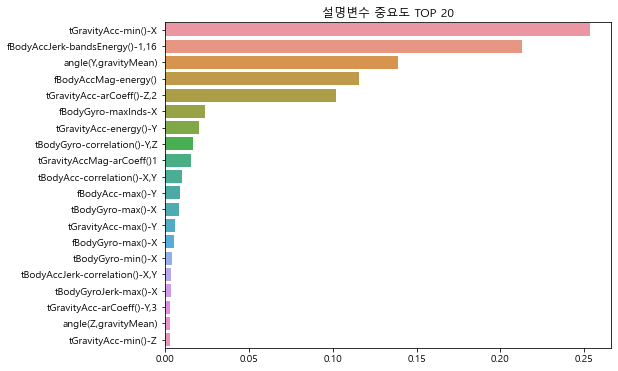

In [47]:
# 한글, 음수 표시
import matplotlib
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)
# 시각화
df_importance_values = best_dt.feature_importances_
# TOP 20
df_importance = pd.Series(df_importance, index = X_train.columns)
importance_top20 = df_importance.sort_values(ascending = False)[:20]
plt.figure(figsize = (8,6))
plt.title("설명변수 중요도 TOP 20")
sns.barplot(x = importance_top20, y = importance_top20.index)
plt.show()